## Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn import metrics
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, StackingRegressor, BaggingRegressor 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

In [72]:
food_waste = pd.read_csv('./data/food_waste.csv')

In [73]:
food_waste.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27773 entries, 0 to 27772
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   m49_code                  27773 non-null  int64  
 1   country                   27773 non-null  object 
 2   region                    871 non-null    object 
 3   cpc_code                  27773 non-null  object 
 4   commodity                 27773 non-null  object 
 5   year                      27773 non-null  int64  
 6   loss_percentage           27773 non-null  float64
 7   loss_percentage_original  27773 non-null  object 
 8   loss_quantity             4552 non-null   object 
 9   activity                  20873 non-null  object 
 10  food_supply_stage         27724 non-null  object 
 11  treatment                 881 non-null    object 
 12  cause_of_loss             925 non-null    object 
 13  sample_size               1176 non-null   object 
 14  method

In [74]:
countries = pd.read_csv('https://raw.githubusercontent.com/albertyw/avenews/master/old/data/average-latitude-longitude-countries.csv')

In [75]:
countries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ISO 3166 Country Code  239 non-null    object 
 1   Country                240 non-null    object 
 2   Latitude               240 non-null    float64
 3   Longitude              240 non-null    float64
dtypes: float64(2), object(2)
memory usage: 7.6+ KB


## Cleaning Data

In [76]:
# iterate through columns that have more than 1000 null variables
for col in food_waste.columns:
    if food_waste[col].isnull().sum() > 10000:
        print(f'{col}: {food_waste[col].isnull().sum()}')

region: 26902
loss_quantity: 23221
treatment: 26892
cause_of_loss: 26848
sample_size: 26597
reference: 19337
notes: 26423


In [77]:
# dropping columns with many null variables, missing data essentially
for col in food_waste.columns:
    if food_waste[col].isnull().sum() > 10000:
        food_waste.drop(col, axis = 1, inplace = True)

In [78]:
# these columns aren't relevant for us to look at
food_waste.drop(columns = ['m49_code', 'cpc_code', 'method_data_collection', 'url'],
             axis = 1, inplace = True)

In [79]:
food_waste.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27773 entries, 0 to 27772
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   country                   27773 non-null  object 
 1   commodity                 27773 non-null  object 
 2   year                      27773 non-null  int64  
 3   loss_percentage           27773 non-null  float64
 4   loss_percentage_original  27773 non-null  object 
 5   activity                  20873 non-null  object 
 6   food_supply_stage         27724 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 1.5+ MB


In [80]:
food_waste.isnull().sum()

country                        0
commodity                      0
year                           0
loss_percentage                0
loss_percentage_original       0
activity                    6900
food_supply_stage             49
dtype: int64

In [81]:
food_waste['activity'].fillna('Missing', inplace = True)
food_waste['food_supply_stage'].fillna('Missing', inplace = True)

In [82]:
food_waste.isnull().sum()

country                     0
commodity                   0
year                        0
loss_percentage             0
loss_percentage_original    0
activity                    0
food_supply_stage           0
dtype: int64

In [83]:
food_waste.head()

,country,commodity,year,loss_percentage,loss_percentage_original,activity,food_supply_stage
0,Myanmar,"Groundnuts, excluding shelled",2009,5.22,5.22%,Missing,Whole supply chain
1,Myanmar,"Groundnuts, excluding shelled",2008,5.43,5.43%,Missing,Whole supply chain
2,Myanmar,"Groundnuts, excluding shelled",2007,5.61,5.61%,Missing,Whole supply chain
3,Myanmar,"Groundnuts, excluding shelled",2006,5.40,5.4%,Missing,Whole supply chain
4,Myanmar,"Groundnuts, excluding shelled",2005,5.00,5%,Missing,Whole supply chain


In [84]:
countries.drop(columns = 'ISO 3166 Country Code', inplace = True)

In [85]:
countries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Country    240 non-null    object 
 1   Latitude   240 non-null    float64
 2   Longitude  240 non-null    float64
dtypes: float64(2), object(1)
memory usage: 5.8+ KB


In [96]:
df = pd.merge(countries, food_waste, left_on = 'Country', right_on='country', how='inner')

In [97]:
df.drop(columns = ['Country',
                   'loss_percentage_original'], inplace = True)

In [98]:
df.to_csv('./merged_df.csv')

### Baseline Accuracy

In [ ]:
df['loss_percentage'].value_counts()

In [ ]:
df['food_supply_stage'].value_counts(normalize = True)

### EDA

In [ ]:
plt.hist(df['loss_percentage'], color = 'orange')
plt.title('Distribution of Loss Percentage')
plt.ylabel('Amount')
plt.xlabel('Loss Percentage');

In [ ]:
df['loss_percentage'].describe()

In [ ]:
fss_bar = df['food_supply_stage'].value_counts().plot(kind = 'barh')
fss_bar.set_title('Barchart of the Food Supply Stage With the Most Amount of Loss')
fss_bar.set_xlabel('Food Supply Stage')
fss_bar.set_ylabel('Number of Listed Producers');

In [ ]:
farm_data = df[df['food_supply_stage'] == 'Farm']
bins = range(1, 7)

plt.hist(farm_data['loss_percentage'], bins = bins)
plt.xlabel('Loss Percentage')
plt.ylabel('Frequency')
plt.title('Distribution of Loss Percentage, for Farm Stage');

In [ ]:
whole_data = df[df['food_supply_stage'] == 'Whole supply chain']
bins = range(1, 7)

plt.hist(whole_data['loss_percentage'], bins = 10)
plt.xlabel('Loss Percentage')
plt.ylabel('Frequency')
plt.title('Distribution of Loss Percentage, for Whole Supply Chain');

In [ ]:
#pip install shapely

In [ ]:
#pip install geopandas

In [ ]:
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

Code source: https://stackoverflow.com/questions/53233228/plot-latitude-longitude-from-csv-in-python-3-6

/var/folders/7v/f5chkx2s22s84wyhzjwys0g00000gn/T/ipykernel_844/1268092456.py:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


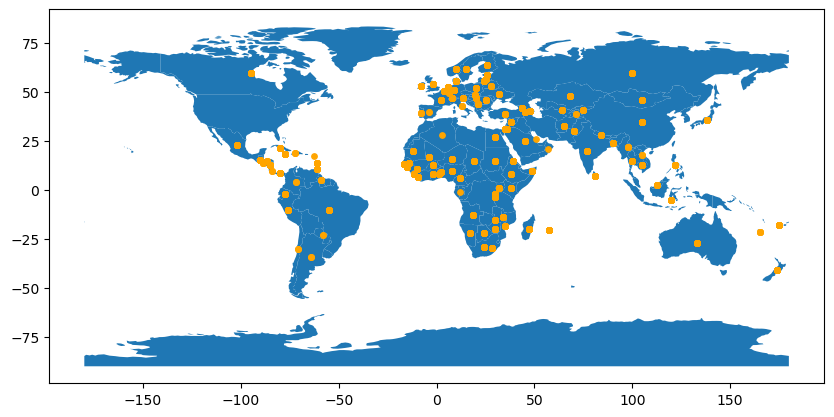

In [57]:
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
gdf = GeoDataFrame(df, geometry=geometry) 

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='orange', markersize=15);

In [49]:
farm_data = df[df['food_supply_stage'] == 'Farm']

In [46]:
geometry = [Point(xy) for xy in zip(farm_data['Longitude'], farm_data['Latitude'])]
gdf = GeoDataFrame(farm_data, geometry=geometry)   

/var/folders/7v/f5chkx2s22s84wyhzjwys0g00000gn/T/ipykernel_844/2272789461.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


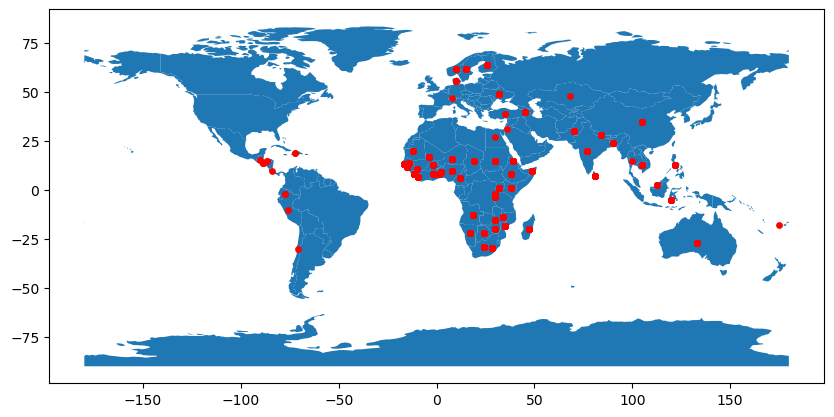

In [47]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

In [58]:
def plot_series(df, cols, title='Title', xlab=None, ylab=None):
    
    # Set figure size to be (18, 9).
    plt.figure(figsize=(18,9))
    
    # Iterate through each column name.
    for col in cols:
        
        # Generate a line plot of the column name.
        # You only have to specify Y, since our
        # index will be a datetime index.
        plt.plot(df[col])
        
    # Generate title and labels.
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    # Enlarge tick marks.
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18);

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23853 entries, 0 to 23852
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Latitude           23853 non-null  float64
 1   Longitude          23853 non-null  float64
 2   country            23853 non-null  object 
 3   commodity          23853 non-null  object 
 4   year               23853 non-null  int64  
 5   loss_percentage    23853 non-null  float64
 6   activity           23853 non-null  object 
 7   food_supply_stage  23853 non-null  object 
dtypes: float64(3), int64(1), object(4)
memory usage: 1.6+ MB


In [101]:
df['year'] = pd.to_datetime(df['year'], format='%Y')

In [102]:
df['year']

0       2017-01-01
1       2017-01-01
2       2017-01-01
3       2017-01-01
4       2016-01-01
           ...    
23848   2000-01-01
23849   2000-01-01
23850   2000-01-01
23851   2000-01-01
23852   2000-01-01
Name: year, Length: 23853, dtype: datetime64[ns]

In [115]:
avg_loss_percentage = df.groupby(df['year'].dt.year)['loss_percentage'].mean()

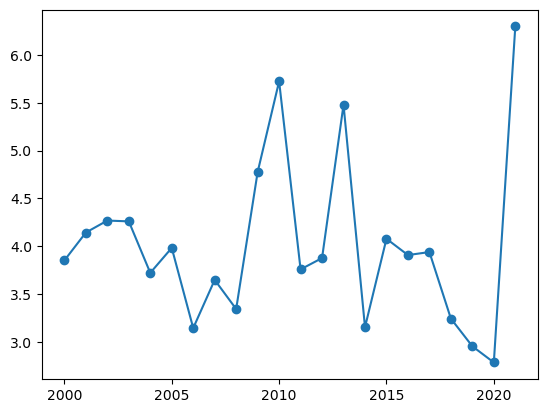

In [116]:
plt.plot(avg_loss_percentage.index, avg_loss_percentage.values, marker='o');

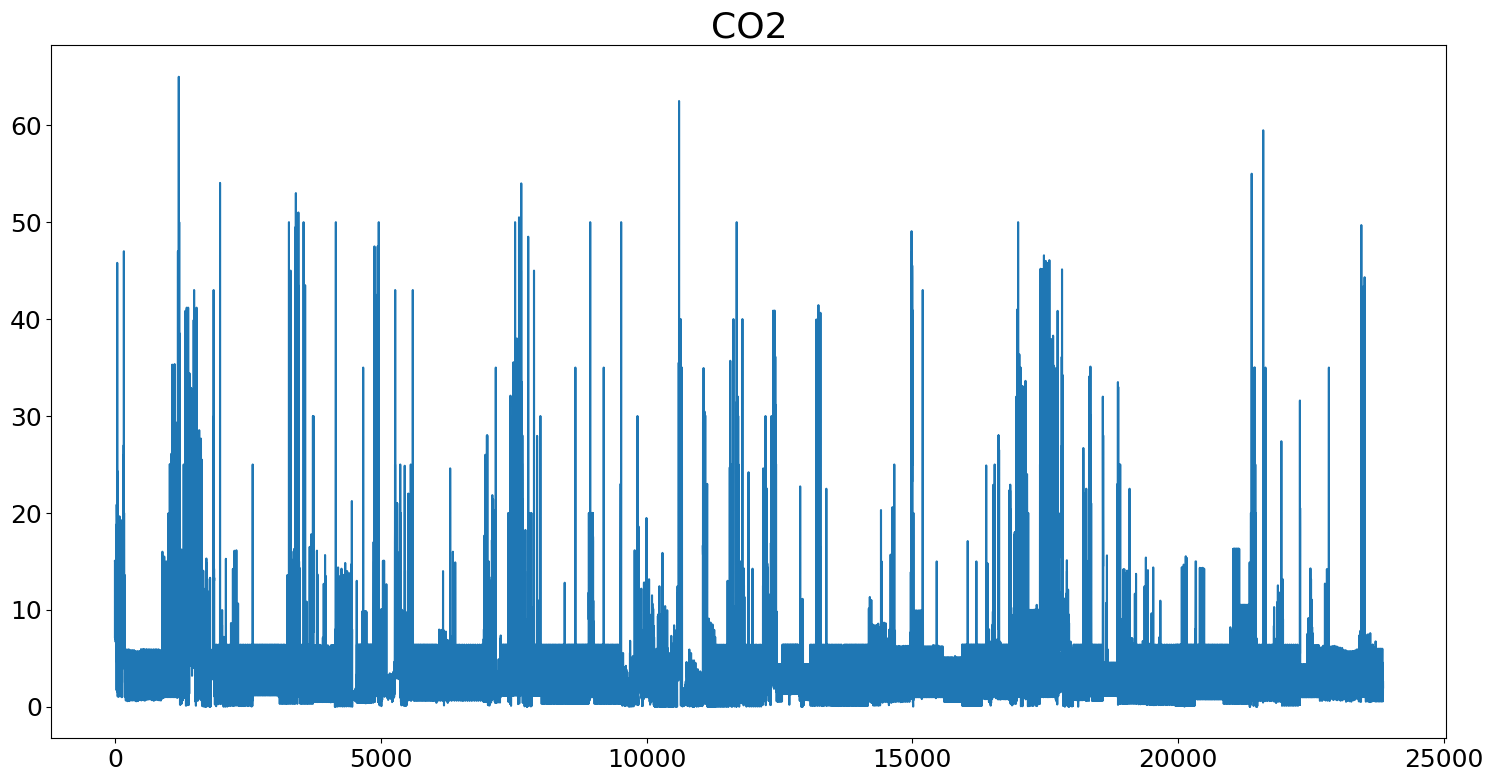

In [62]:
plot_series(df, cols = [''], title = 'CO2')

/var/folders/7v/f5chkx2s22s84wyhzjwys0g00000gn/T/ipykernel_844/3505088026.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  supply_corr = df.corr()


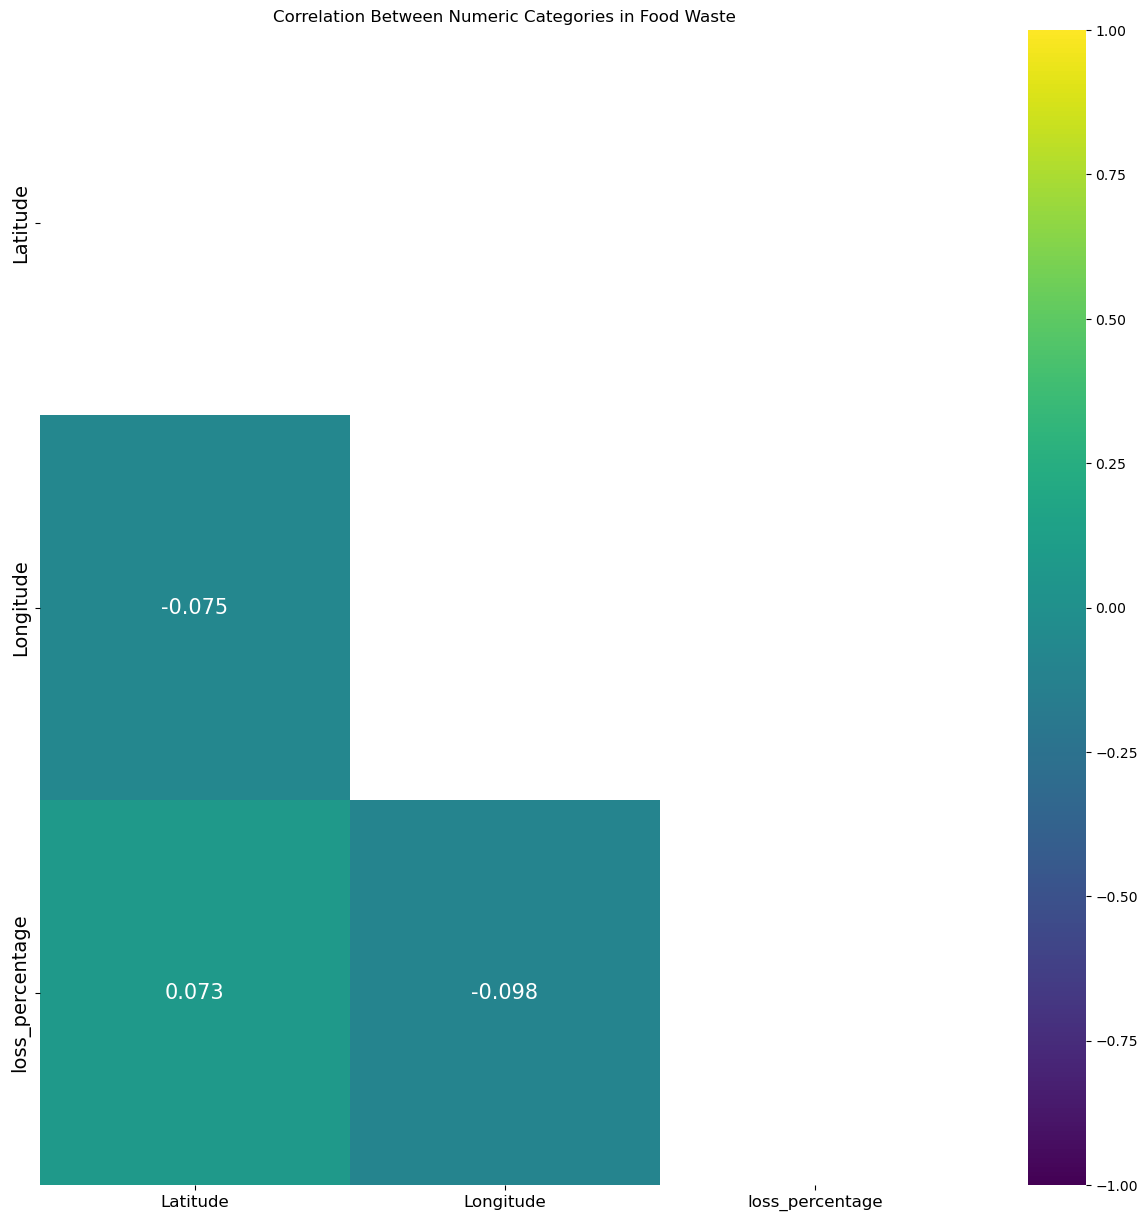

In [117]:
supply_corr = df.corr()
mask = np.zeros_like(supply_corr)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize = (15,15))
sns.heatmap(supply_corr,
            cmap = 'viridis',
            vmax = 1,
            vmin = -1,
            annot = True,
            mask = mask,
            annot_kws={'size': 15})

plt.title('Correlation Between Numeric Categories in Food Waste')
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 12);

## Functions Used

### Hyperparamters Functions
* best_params: returns the best score and paramters for pipeline/model
* return_gs: returns the optimal paramters of a pipeline/model
* tts_scores: returns the Train and Test scores of a pipeline/model

In [118]:
def best_params(pipeline, params, X_train, y_train):
    gs = GridSearchCV(pipeline,
                      param_grid = params,
                      n_jobs=-1)

    gs.fit(X_train, y_train)
    
    return f'Best Score: {gs.best_score_}, Params: {gs.best_params_}'

In [119]:
def return_gs(pipeline, params, X_train, y_train):
    gs = GridSearchCV(pipeline,
                      param_grid = params,
                      n_jobs=-1)
    return gs

In [120]:
def tts_scores(gs, X_train, y_train, X_test, y_test):
    gs.fit(X_train, y_train)
    
    return f'Train Score: {gs.score(X_train, y_train)}, Test Score: {gs.score(X_test, y_test)}'

### Evaluation Functions
* predictions: accepts a pipeline and returns the predictions for y
* regression_scores: returns DataFrame of data for a model and its regression metric scores (R2, MSE, and RMSE)
* classification_scores: returns DataFrame of data fro a model and its classification metric scores (recall, precision, f1, accuracy)

In [121]:
def predictions(pipeline, X_train, X_test, y_train):
    pipeline.fit(X_train, y_train)
    prediction = pipeline.predict(X_test)
    
    return prediction

In [122]:
def regression_scores(model, y_test, y_pred):
    dataframe = pd.DataFrame(columns = ['R2', 'MSE', 'RMSE'])
    
    r2 = metrics.r2_score(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = round(mse**0.5, 4)
    
    dataframe.loc[model] = [r2, mse, rmse]
    
    pd.options.display.float_format = '{:.4f}'.format 
    
    return dataframe

In [123]:
def regression_scores(model, y_test, y_pred):
    dataframe = pd.DataFrame(columns = ['R2', 'MSE', 'RMSE'])
    
    r2 = round(metrics.r2_score(y_test, y_pred), 4)
    mse = round(metrics.mean_squared_error(y_test, y_pred), 4)
    rmse = round(mse**0.5, 4)
    
    dataframe.loc[model] = [r2, mse, rmse]
    
    return dataframe

In [124]:
def classification_scores(model, y_test, y_pred):
    dataframe = pd.DataFrame(columns = ['Recall', 'Precision', 'F1', 'Accuracy'])
    
    recall = recall_score(y_test, y_pred, average = 'micro')
    precision = precision_score(y_test, y_pred, average = 'micro')
    f1 = f1_score(y_test, y_pred, average = 'micro')
    accuracy = accuracy_score(y_test, y_pred)
    
    dataframe.loc[model] = [recall, precision, f1, accuracy]
    
    return dataframe

### Train-Test-Split (for Regression)

In [125]:
random.seed(42) # set random seed

In [126]:
df_dummy = pd.get_dummies(df, columns = ['country',
                             'commodity',
                             'year',
                             'activity',
                             'food_supply_stage'])

In [127]:
X = df_dummy.drop(columns = 'loss_percentage')
y = df_dummy['loss_percentage']

In [128]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

### Linear Regression
Regression problem with continous variables

In [129]:
lr_pipe = Pipeline([
    ('ss', StandardScaler()),
    ('lr', LinearRegression())
])

In [130]:
lr_params = {
    'ss__with_mean': [False, True],
    'ss__with_std': [False, True],
    'lr__fit_intercept': [False, True],
    'lr__n_jobs': [25, 50, 100, 250],
    'lr__positive': [False, True]
}

In [131]:
best_params(lr_pipe, lr_params, X_train, y_train)

"Best Score: 0.48314906820631476, Params: {'lr__fit_intercept': False, 'lr__n_jobs': 25, 'lr__positive': True, 'ss__with_mean': False, 'ss__with_std': False}"

In [132]:
lr_gs = return_gs(lr_pipe, lr_params, X_train, y_train)

In [133]:
tts_scores(lr_gs, X_train, y_train, X_test, y_test)

'Train Score: 0.5370887616323707, Test Score: 0.45601898640936145'

* Evaluation

In [134]:
lr_pred = predictions(lr_pipe, X_train, X_test, y_train)

In [135]:
model_table = regression_scores('LinearRegression', y_test, lr_pred)

### RandomForest

In [136]:
rfr_pipe = Pipeline([
    ('ss', StandardScaler()),
    ('rfr', RandomForestRegressor())
])

In [137]:
rfr_params = {
    'ss__with_mean': [False, True],
    'ss__with_std': [False, True],
    'rfr__n_estimators': [100, 150, 200, 250],
    'rfr__bootstrap': [True, False]
    
}

In [138]:
best_params(rfr_pipe, rfr_params, X_train, y_train)

"Best Score: 0.7014952795674533, Params: {'rfr__bootstrap': True, 'rfr__n_estimators': 200, 'ss__with_mean': False, 'ss__with_std': False}"

In [139]:
rfr_gs = return_gs(rfr_pipe, rfr_params, X_train, y_train)

In [140]:
tts_scores(rfr_gs, X_train, y_train, X_test, y_test)

'Train Score: 0.9287932153710325, Test Score: 0.6859126677188659'

In [ ]:
# yikes so overfit

* Evaluation

In [141]:
rfr_pred = predictions(rfr_pipe, X_train, X_test, y_train)

In [142]:
model_table = pd.concat([model_table, regression_scores('RandomForest', y_test, rfr_pred)])

### AdaBoostRegressor

In [144]:
ada_pipe = Pipeline([
    ('ss', StandardScaler()),
    ('ada', AdaBoostRegressor())
])

In [145]:
ada_params = {
    'ss__with_mean': [False, True],
    'ss__with_std': [False, True],
    'ada__n_estimators': [25, 50, 100, 150, 200],
    'ada__learning_rate': [1, 0.9, 1.1]
}

In [146]:
best_params(ada_pipe, ada_params, X_train, y_train)

"Best Score: 0.09894456721009011, Params: {'ada__learning_rate': 0.9, 'ada__n_estimators': 50, 'ss__with_mean': False, 'ss__with_std': False}"

In [147]:
ada_gs = return_gs(ada_pipe, ada_params, X_train, y_train)

In [148]:
tts_scores(ada_gs, X_train, y_train, X_test, y_test)

'Train Score: -0.011397390445074596, Test Score: -0.035100410380480174'

* Evaluation

In [149]:
ada_pred = predictions(ada_pipe, X_train, X_test, y_train)

In [150]:
model_table = pd.concat([model_table, regression_scores('AdaBoost', y_test, ada_pred)])

### Regression: Stacking

In [ ]:
level1_estimators =[
    ('rfr_pipe', Pipeline([
        ('ss', StandardScaler()),
        ('rfr', RandomForestRegressor())
    ])), 
    ('dt_pipe', Pipeline([
        ('ss', StandardScaler()),
        ('dt', DecisionTreeRegressor())
    ])),  
    ('bag_pipe', Pipeline([
        ('ss', StandardScaler()),
        ('bag', BaggingRegressor())
    ])),       
]

In [ ]:
stacked_model = StackingRegressor(estimators = level1_estimators,
                                 final_estimator = LinearRegression())

In [ ]:
cross_val_score(stacked_model, X_train, y_train).mean()

In [ ]:
stacked_model.fit(X_train, y_train)

In [ ]:
stacked_model.score(X_train, y_train), stacked_model.score(X_test, y_test)

* Evaluation

In [ ]:
stacked_pred = predictions(stacked_model, X_train, X_test, y_train)

In [ ]:
model_table = pd.concat([model_table, regression_scores('Stacking', y_test, stacked_pred)])

In [ ]:
model_table

### Imbalaced Data Methods

## Classification

In [151]:
df['food_supply_stage'].value_counts(normalize = True)

Farm                  0.469249
Whole supply chain    0.179600
Harvest               0.140234
Storage               0.098688
Transport             0.071731
Wholesale             0.009559
Processing            0.009223
Retail                0.008930
Trader                0.003060
Households            0.002138
Export                0.002096
Post-harvest          0.001845
Missing               0.001803
Food Services         0.000587
Distribution          0.000419
Pre-harvest           0.000419
Market                0.000377
Stacking              0.000042
Name: food_supply_stage, dtype: float64

In [152]:
features = pd.get_dummies(df, columns = ['Longitude', 'Latitude','country',
                              'commodity',
                              'year',
                              'activity'])

In [153]:
X = features.drop(columns = 'food_supply_stage')

In [154]:
y = pd.get_dummies(df['food_supply_stage'], columns = ['food_supply_stage'])

In [155]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

### DecisionTreeClassifier

In [156]:
dt_pipe = Pipeline([
    ('ss', StandardScaler()),
    ('dt', DecisionTreeClassifier())
])

In [157]:
dt_params = {
    'ss__with_mean': [False, True],
    'ss__with_std': [False, True],
    'dt__max_depth': [1, 5, 10, 25, 100],
    'dt__min_samples_leaf': [1, 3, 6, 10],
    'dt__min_samples_split': [5, 10, 15, 20]
}

In [158]:
best_params(dt_pipe, dt_params, X_train, y_train)

"Best Score: 0.9547206525511649, Params: {'dt__max_depth': 100, 'dt__min_samples_leaf': 1, 'dt__min_samples_split': 5, 'ss__with_mean': True, 'ss__with_std': True}"

In [159]:
dt_gs = return_gs(dt_pipe, dt_params, X_train, y_train)

In [160]:
tts_scores(dt_gs, X_train, y_train, X_test, y_test)

'Train Score: 0.9808262060484096, Test Score: 0.9585848423876593'

In [161]:
### Evaluation: omg these are good scores, did I do this right 

In [162]:
dt_pred = predictions(dt_pipe, X_train, X_test, y_train)

In [163]:
class_model = classification_scores('DecisionTree', y_test, dt_pred)

In [164]:
class_model

,Recall,Precision,F1,Accuracy
DecisionTree,0.961603,0.962571,0.962087,0.961603


### LogisticRegression

In [165]:
features = pd.get_dummies(df, columns = ['Longitude', 'Latitude','country',
                              'commodity',
                              'year',
                              'activity'])

In [166]:
X = features.drop(columns = 'food_supply_stage')
y = df['food_supply_stage']

In [167]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [168]:
log_pipe = Pipeline([
    ('ss', StandardScaler()),
    ('lr', LogisticRegression(multi_class='multinomial', 
                              max_iter = 1000, 
                              solver='saga'))
])

In [169]:
log_params = {
    'ss__with_mean': [False, True],
    'ss__with_std': [False, True],
    'lr__penalty': ['l1', 'l2', 'elasticnet', None]
}

In [ ]:
best_params(log_pipe, log_params, X_train, y_train)

In [ ]:
log_gs = return_gs(log_pipe, log_params, X_train, y_train)

In [ ]:
tts_scores(log_gs, X_train, y_train, X_test, y_test)

In [ ]:
log_pred = predictions(log_pipe, X_train, X_test, y_train)

In [ ]:
class_model = pd.concat([class_model, regression_scores('LogisticRegression', y_test, log_pred)])

### Stacking: Classification

In [ ]:
level1_estimators =[
    ('rfr_pipe', Pipeline([
        ('ss', StandardScaler()),
        ('rfr', RandomForestClassifier())
    ])), 
    ('dt_pipe', Pipeline([
        ('ss', StandardScaler()),
        ('dt', DecisionTreeClassifier())
    ])),  
    ('bag_pipe', Pipeline([
        ('ss', StandardScaler()),
        ('bag', BaggingClassifier())
    ])),       
]

In [ ]:
stacked_model = StackingRegressor(estimators = level1_estimators,
                                 final_estimator = LogisticRegression())

In [ ]:
cross_val_score(stacked_model, X_train, y_train).mean()

In [ ]:
stacked_model.fit(X_train, y_train)

In [ ]:
stacked_model.score(X_train, y_train), stacked_model.score(X_test, y_test)

### Attempting AdaSyn

In [ ]:
dt_ada_pipe = make_pipeline(
    ADASYN(random_state = 34),
    DecisionTreeClassifier()
)

In [ ]:
dt_ada_params = {
    'decisiontreeclassifier__max_depth':[100,200,300],
    'decisiontreeclassifier__min_samples_split': [2, 3, 4, 5]
}

In [ ]:
dt_ada_gs = GridSearchCV(dt_ada_pipe, 
                         dt_ada_params,
                         scoring = 'balanced_accuracy',
                         n_jobs = -1
                        )

In [ ]:
dt_ada_gs.fit(X_train, y_train)

In [ ]:
dt_ada_gs.score(X_test_ss, y_test)

In [ ]:
dt_sm_pipe = make_pipeline(
    SMOTE(), 
    DecisionTreeClassifier())

In [ ]:
dt_sm_gs = GridSearchCV(
    dt_sm_pipe, 
    {'decisiontreeclassifier__max_depth':[100,200,300],
    'decisiontreeclassifier__min_samples_split': [2, 3, 4, 5]}, 
    scoring='balanced_accuracy'
)

In [ ]:
dt_sm_gs.fit(X_train, y_train)

### Unsupervised Learning

In [ ]:
df.info()

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer

In [ ]:
cat_col = ['country', 'commodity', 'activity', 'food_supply_stage']
num_col = ['Latitude', 'Longitude', 'loss_percentage', 'year']

transformer = make_column_transformer(
            (OneHotEncoder(), cat_col),
            (StandardScaler(), num_col)
)

In [ ]:
df_tf = transformer.fit_transform(df)

In [ ]:
ss = StandardScaler(with_mean = False)
X_sc = ss.fit_transform(df_tf)

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
km = KMeans(n_clusters = 8, random_state = 42, n_init = 10)
km.fit(X_sc)

In [ ]:
km.n_clusters

In [ ]:
km.predict(X_sc)

In [ ]:
df_copy = df.copy()

In [ ]:
df_copy['cluster'] = km.labels_

In [ ]:
df_copy.groupby('cluster').mean()

In [ ]:
# Take a look at the data using a scatterplot
df.plot(kind="scatter", x="Latitude", y="Longitude", figsize=(12,6), s=50)
plt.xlabel("Latitude", fontsize=18)
plt.ylabel("Longitude", fontsize=18);